# KC House Data

## Importing and cleaning the data

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

##############################
# notebook parameters

# import warnings
# warnings.filterwarnings('ignore')
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
sns.set(rc={'figure.figsize':(12,9)})

kc = pd.read_csv('./source/kc_house_data.csv', parse_dates=[1,14])

##############################
## Cleaning the data

# waterfront, although incomplete, hasn't been altered due to the complexity of the variable assignment

# sqft_basement: 454 '?' values changed to zero.
properties_data_altered = {} # lists the properties with altered data
for i in range(0,len(kc['id'])-1):
        if kc['sqft_basement'][i] == '?':
            kc['sqft_basement'][i] = 0
        properties_data_altered[kc['id'][i]] = 'sqft_basement'

# 33 bedrooms house? It is a typo (the 11 bedrooms one seems to check out though)
properties_data_altered[kc[kc['bedrooms']==33].iloc[0]['id']] = '33_bedrooms'
kc['bedrooms'] = kc['bedrooms'].replace(33,3)

# view, 63 empties changed to zeros
for i in kc[kc['view'].isnull()]['id']:
    properties_data_altered[i] = 'views'
kc['view'] = kc['view'].fillna(0)

# yr_renovated, 16900 zeros changed to NaN
for i in kc[kc['yr_renovated']=='0.0']['id']:
    properties_data_altered[i] = 'yr_renovated'
kc['yr_renovated'] = kc['yr_renovated'].replace('0.0', np.nan)

##############################
# sorting out data types:

# lines are commented to allow us to work on non categorised data
kc['id'] = kc['id'].astype(str)
# kc['bathrooms'] = kc['bathrooms'].astype(str)
# kc['bedrooms'] = kc['bedrooms'].astype(str)
# kc['condition'] = kc['condition'].astype(str)
# kc['floors'] = kc['floors'].astype(str)
# kc['grade'] = kc['grade'].astype(str)
kc['sqft_basement'] = kc['sqft_basement'].astype(float)
# kc['view'] = kc['view'].astype(str)
kc['waterfront'] = kc['waterfront'].astype(str)
kc['yr_renovated'] = pd.to_datetime(kc['yr_renovated'])
#kc['zipcode'] = kc['zipcode'].astype(str)

<ipython-input-2-48fdfe21b1a4>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc['sqft_basement'][i] = 0
/home/antoine/.local/lib/python3.8/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## Generating the subdatasets

In [3]:
# split dataframes: properties sold more than once in the timeframe vs all properties without duplicates
duplicate_properties = kc[kc.duplicated(['id'],keep=False)]
kc = kc.sort_values('date').drop_duplicates('id',keep='last')

# our area of focus, based on the price evolution analysed in kc_duplicated
focus_zipcodes = [
    '98034','98011','98028','98155','98133','98177','98125','98115','98103','98117','98107','98199'
]

# our main dataset
kayCee = kc[kc['zipcode'].isin(focus_zipcodes)] # 4905 houses

## Analysing the market growth based on multiple entry properties

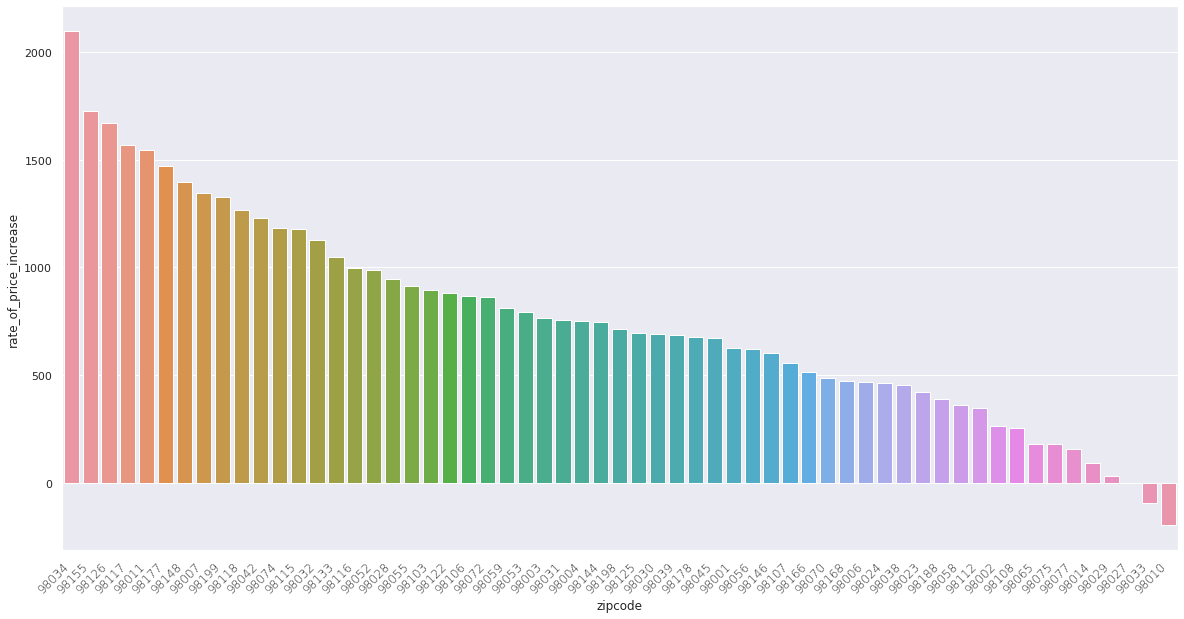

In [4]:
##############################
# Insert columns and sets the type

duplicate_properties.insert(2,"time_diff",0)
duplicate_properties.insert(4,"price_diff",0)
duplicate_properties.insert(5,"rate_of_price_increase",0)
duplicate_properties["date"] = pd.to_datetime(duplicate_properties['date'])
duplicate_properties["time_diff"] = pd.to_datetime(duplicate_properties['time_diff'])

##############################
# resetting the index and dropping the middle value of the property sold 3 times during timeframe

duplicate_properties = duplicate_properties.reset_index()
duplicate_properties = duplicate_properties.drop("index", 1)
duplicate_properties = duplicate_properties.drop(317)
duplicate_properties = duplicate_properties.reset_index()
duplicate_properties = duplicate_properties.drop("index", 1)

##############################
# calculating the price increase and the time spent between sales

duplicate_properties['time_diff'] = duplicate_properties.groupby(['id'])['date'].shift(1) #run a lag operation on dates
duplicate_properties['price_diff'] = duplicate_properties.groupby(['id'])['price'].shift(1) #run a lag operation on prices
duplicate_properties["time_diff"] = duplicate_properties['date'] - duplicate_properties['time_diff'] #get the date difference and add it to 'time_diff' column
duplicate_properties["price_diff"] = duplicate_properties['price'] - duplicate_properties['price_diff'] #get the price difference and add it to 'price_diff' column
analysis_df = duplicate_properties.copy()

for row in range(0,len(analysis_df),2):
     analysis_df.drop(index=row,inplace=True)
        
analysis_df.insert(3,"time_diff_seconds",0) #add a column for time difference as an int
analysis_df["time_diff_seconds"] = pd.to_numeric(analysis_df["time_diff"])/1000000000 #convert timedelta obeject to seconds (stored as ns by default)
analysis_df["rate_of_price_increase"] = analysis_df["price_diff"]/(analysis_df["time_diff_seconds"]/86400) #calculate rate of increase in prices

##############################
# creating a dataframe to generate the graph

hot_zip_codes = analysis_df.groupby(["zipcode"])["rate_of_price_increase"].mean() #create a Pandas series of rate of the mean rate of price inrease grouped by zip code
hot_zip_codes = analysis_df.groupby(["zipcode"]).mean() #group everything by zipcode and take the mean
hot_zip_codes_count = analysis_df.groupby(["zipcode"]).count() #group everything by zipcode and run a count
hot_zip_codes.drop(columns = ["time_diff_seconds", "price", "price_diff", "bedrooms", "bathrooms"],inplace = True) #remove extranous columns
hot_zip_codes.drop(columns = ["sqft_living", "sqft_lot", "floors", "view", "condition"],inplace = True) #remove extranous columns
hot_zip_codes.drop(columns = ["grade", "sqft_above", "sqft_living15", "sqft_lot15"],inplace = True) #remove extranous columns
hot_zip_codes.sort_values(ascending = False, inplace = True, by="rate_of_price_increase")  #sort hot zip codes in descending order
hot_zip_codes.reset_index(level=0, inplace=True)
hot_zip_codes = hot_zip_codes.sort_values(['rate_of_price_increase']).reset_index(drop=True)
y_axis = [
    98034, 98155, 98126, 98117, 98011, 98177, 98148, 98007, 98199, 98118, 98042, 98074, 98115,
    98032, 98133, 98116, 98052, 98028, 98055, 98103, 98122, 98106, 98072, 98059, 98053, 98003,
    98031, 98004, 98144, 98198, 98125, 98030, 98039, 98178, 98045, 98001, 98056, 98146, 98107,
    98166, 98070, 98168, 98006, 98024, 98038, 98023, 98188, 98058, 98112, 98002, 98108, 98065,
    98075, 98077, 98014, 98029, 98027, 98033, 98010
         ]

##############################
# generating the graph

plt.figure(figsize=(20,10))
chart = sns.barplot(x = "zipcode", 
                    y = "rate_of_price_increase", 
                    data = hot_zip_codes, 
                    order = y_axis)

chart.set_xticklabels(chart.get_xticklabels(), 
                      rotation=45, 
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large');

As this chart summarizes, almost all the zipcodes have seen a positive growth between May14 and May15. Some zipcodes (98034) have yield up to $2000 per day!

## Seasonality

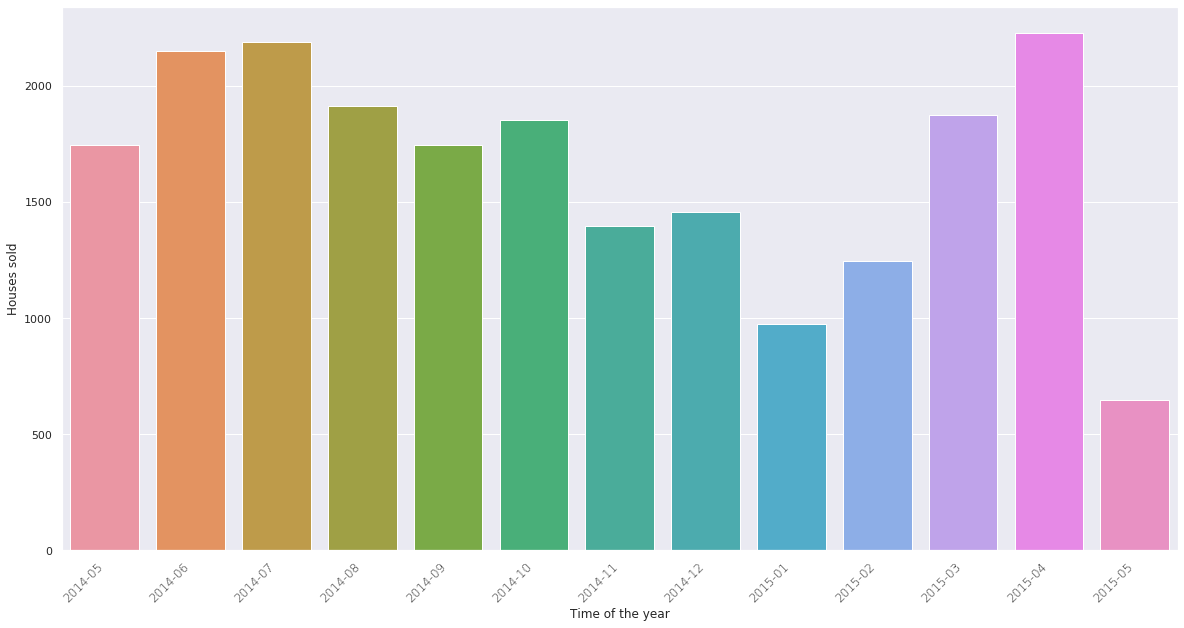

In [5]:
##############################
# generate a dataset to analyse the seasonality of data

seasonality_df = kc.copy() #copy main data
seasonality_df.insert(3,"month",0) #add a column for time month
seasonality_df.insert(4,"year",0) #add a column for time year
seasonality_df["date"] = pd.to_datetime(seasonality_df['date']) #convert date column to datetime objects from object
seasonality_df["month"] = seasonality_df["date"].dt.month #extract month
seasonality_df["year"] = seasonality_df["date"].dt.year #extract year
per_month = seasonality_df.set_index('date').groupby(pd.Grouper(freq='M'))['id'].count() #create a Pandas series with the values we need

##############################
# generate the seasonality graph

plt.figure(figsize=(20,10)) 
chart = sns.barplot(
                    x = per_month.index, 
                    y = per_month.values
                   )
xlabels = ['2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12','2015-01','2015-02','2015-03','2015-04','2015-05']
chart.set_xlabel('Time of the year')
chart.set_ylabel('Houses sold');

chart.set_xticklabels(xlabels,
                      rotation=45, 
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large');

An analysis of the dates at which (all) the properties were sold confirms that the market is picking up during February, reaches peak from May to August, then is declining until late winter.

The first and last month need to be analysed with caution as the data is most likely truncated (under reporting most likely due due to the dataset not covering the whole month, numbers not being available yet, etc.)

## Non-renovated development within the hot zone

Non renovated properties are generally cheaper than renovated ones.

The properties showing the highest potential return are the ones in poor conditions (1 and 2). If brought to condition 3 would on average sell for 542,000 (condition 1 to 3, 3 bedrooms).

In [6]:
no_renovation = kayCee[kayCee.yr_renovated=='1970-01-01 00:00:00.000000000']

no_renovation_1 = no_renovation[no_renovation.condition==1] # 4 properties
no_renovation_1.price.min() # 125,000
no_renovation_1.price.median() # 233,000
no_renovation_1.price.max() # 352,950

no_renovation_2 = no_renovation[no_renovation.condition==2] # 19 properties
no_renovation_2.price.min() # 237,000
no_renovation_2.price.median() # 420,550
no_renovation_2.price.max() # 975,000

no_renovation_3 = no_renovation[no_renovation.condition==3] # 2384 properties
no_renovation_3.price.min() # 130,000
no_renovation_3.price.median() # 465,000
no_renovation_3.price.max() # 4,500,000

no_renovation_4 = no_renovation[no_renovation.condition==4] # 969 properties
no_renovation_4.price.min() # 195,000
no_renovation_4.price.median() # 476,000
no_renovation_4.price.max() # 3,070,000

no_renovation_5 = no_renovation[no_renovation.condition==5] # 410 properties
no_renovation_5.price.min() # 238,000
no_renovation_5.price.median() # 570,000
no_renovation_5.price.max() # 3,000,000


3000000.0

Average price of a 3 beds property:

In [9]:
renovated[renovated['bedrooms']==3]['price'].mean()

541811.234939759

## Renovated development within the hot zone

For properties already renovated, the price tag is slightly higher but some properties still have a high profit potential; the renovated_1 property could yield 33% - minus renovation costs - if brought to a condition 3 (compared to the average price of 2 bedrooms house)

In [8]:
renovated = kayCee[kayCee.yr_renovated!='1970-01-01 00:00:00.000000000']

renovated_1 = renovated[renovated.condition==1] # 1 property
renovated_1.price.min() # 305,000
renovated_1.price.median() # 305,000
renovated_1.price.max() # 305,000

renovated_2 = renovated[renovated.condition==2] # 2 properties
renovated_2.price.min() # 400,000
renovated_2.price.median() # 524,975
renovated_2.price.max() # 649,950

renovated_3 = renovated[renovated.condition==3] # 744 properties
renovated_3.price.min() # 90,000
renovated_3.price.median() # 499,000
renovated_3.price.max() # 3,200,000

renovated_4 = renovated[renovated.condition==4] # 273 properties
renovated_4.price.min() # 230,000
renovated_4.price.median() # 483,000
renovated_4.price.max() # 2,230,000

renovated_5 = renovated[renovated.condition==5] # 99 properties
renovated_5.price.min() # 291,500
renovated_5.price.median() # 625,000
renovated_5.price.max() # 1,580,000

1580000.0

Average price of a 2 bedrooms renovated property:

In [10]:
renovated[renovated['bedrooms']==2]['price'].mean()

459771.5141509434

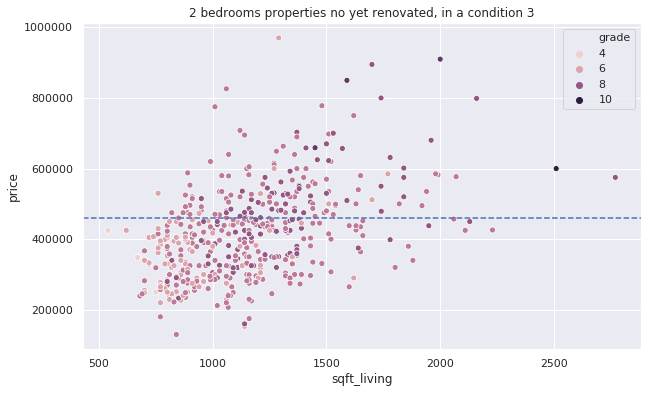

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot('sqft_living', 'price', data=no_renovation_3[no_renovation_3.bedrooms==2], hue='grade')
plt.title('2 bedrooms properties no yet renovated, in a condition 3')
y_average = renovated[renovated['bedrooms']==2]['price'].mean()
ax.axhline(y_average, ls='--');
# plt.xlim(0,5000)
# plt.ylim(0,2500000)

In [12]:
map_kc = gpd.read_file('source/Zip_Codes/Zip_Codes.shp')
map_kc['zipcode'] = map_kc['ZIPCODE']
map_kc.drop(['ZIP', 'ZIPCODE', 'OBJECTID'], axis=1, inplace=True)
merged = pd.merge(map_kc, kc_zip_mean, on='zipcode')

hot_zip_codes.reset_index(inplace=True)
hot_zip_codes['zipcode']=hot_zip_codes['zipcode'].astype(str)
hot_zip_codes.drop(['lat', 'long'], axis=1, inplace=True)
hot_zip_codes
appended_data = []

for zipcode in list(kc['zipcode'].unique()):
    if zipcode not in list(hot_zip_codes['zipcode']):
        appended_data.append({'zipcode':zipcode, 'rate_of_price_increase':0})
        
appended_df = pd.DataFrame(data=appended_data)

merged_df = pd.concat([hot_zip_codes, appended_df], axis=0)

merged_df['zipcode'].nunique()

merged_2 = pd.merge(merged, merged_df, on='zipcode')
gdf=gpd.GeoDataFrame(merged_2, geometry=merged_2.geometry)

gdf.plot(column='rate_of_price_increase', k=5, colormap='OrRd', legend=True, figsize=(20,12))
plt.show()

<ipython-input-12-4cd70c177d57>:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  merged_df = pd.concat([hot_zip_codes, appended_df], axis=0)


NameError: name 'merged' is not defined